In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import unpatchify
from tensorflow.keras.models import load_model
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score as f1_metric
from collections import defaultdict

from preprocess import padder  # crop/crop_to_coordinates removed, since patches are pre-cut
from helpers import f1

def load_patches_sequence(image_dir, time_steps=15, patch_size=256):
    """
    Load patches and group them into temporal sequences of shape:
    (num_sequences, time_steps, patch_size, patch_size, 3).
    """
    patch_dict = defaultdict(list)

    # Group patches by (experiment, plate, patch_id)
    for file in os.listdir(image_dir):
        if file.endswith('.png'):
            exp, plate, day, patch_id = file.replace('.png', '').split('_')
            day = int(day)
            patch_path = os.path.join(image_dir, file)
            patch_dict[(exp, plate, patch_id)].append((day, patch_path))

    sequences = []

    # Sort each group by day and create sequences
    for key, day_patch_list in patch_dict.items():
        # Sort by day
        day_patch_list.sort(key=lambda x: x[0])

        # Load patches as float32 RGB
        patches = [cv2.imread(p[1], cv2.IMREAD_COLOR) / 255.0 for p in day_patch_list]
        patches = [cv2.resize(p, (patch_size, patch_size)) for p in patches]

        # Pad or truncate to time_steps
        if len(patches) < time_steps:
            patches += [patches[-1]] * (time_steps - len(patches))
        else:
            patches = patches[:time_steps]

        sequence = np.stack(patches, axis=0)  # (time_steps, H, W, 3)
        sequences.append((key, sequence))     # Save key for matching masks

    return sequences


def pipeline(image_dir, mask_dir=None, time_steps=15, patch_size=256):
    """
    Full pipeline for LSTM U-Net inference and metric evaluation.
    """
    model_path = "lstm_unet_model.h5"
    model = load_model(model_path, custom_objects={"f1": f1})

    all_f1 = []
    all_iou = []
    all_precision = []
    all_recall = []

    if mask_dir is None:
        mask_dir = image_dir.replace('images/images', 'masks/masks')

    # Load image sequences
    sequences = load_patches_sequence(image_dir, time_steps=time_steps, patch_size=patch_size)
    print(f"Loaded {len(sequences)} patch sequences.")

    for key, seq in sequences:
        # Model expects shape (batch, time_steps, H, W, 3)
        seq_input = np.expand_dims(seq, axis=0)  # (1, time_steps, 256, 256, 3)

        # Predict
        predicted_seq = model.predict(seq_input)  # (1, time_steps, H, W, 1)
        predicted_seq = predicted_seq[0]  # (time_steps, H, W, 1)

        # Take the last time-step mask as final prediction
        prediction = predicted_seq[-1, :, :, 0]
        prediction_bool = (prediction > 0.5).astype(np.uint8)

        # Load mask (final day ground truth)
        exp, plate, patch_id = key[0], key[1], key[2]
        mask_file = f"{exp}_{plate}_{time_steps:02d}_{patch_id}.tif"  # final day mask
        mask_path = os.path.join(mask_dir, mask_file)
        if not os.path.exists(mask_path):
            print(f"Mask {mask_file} not found, skipping...")
            continue
        mask = cv2.imread(mask_path, 0) / 255.0
        mask_bool = (mask > 0.5).astype(np.uint8)

        # Flatten for metrics
        pred_flat = prediction_bool.flatten()
        mask_flat = mask_bool.flatten()

        # Metrics
        f1_val = f1_metric(mask_flat, pred_flat)
        iou_val = jaccard_score(mask_flat, pred_flat)
        precision_val = precision_score(mask_flat, pred_flat)
        recall_val = recall_score(mask_flat, pred_flat)

        all_f1.append(f1_val)
        all_iou.append(iou_val)
        all_precision.append(precision_val)
        all_recall.append(recall_val)

        print(f"Metrics for {key}:")
        print(f"  F1 Score: {f1_val:.4f} | mIoU: {iou_val:.4f} | Precision: {precision_val:.4f} | Recall: {recall_val:.4f}\n")

        # Plot the last image and masks
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(seq[-1])  # last time-step image
        axs[0].set_title("Original Image (Last Day)")
        axs[0].axis("off")

        axs[1].imshow(prediction_bool, cmap='gray')
        axs[1].set_title("Predicted Mask")
        axs[1].axis("off")

        axs[2].imshow(mask_bool, cmap='gray')
        axs[2].set_title("Ground Truth Mask")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

    if all_f1:
        print("=== Average Metrics ===")
        print(f"Avg F1 Score: {np.mean(all_f1):.4f}")
        print(f"Avg mIoU: {np.mean(all_iou):.4f}")
        print(f"Avg Precision: {np.mean(all_precision):.4f}")
        print(f"Avg Recall: {np.mean(all_recall):.4f}")
    else:
        print("No valid sequences/masks were processed.")


# Example usage
pipeline('data_v3_processed/test/images/images')


Loaded 23 patch sequences.
1/1 [==============================] - 1s 559ms/step


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

Found 23 (exp, plate, patch) groups in data_v3_processed/test/images/images.
Built 23 sequences (each padded/truncated to 15 frames).
1/1 [==============================] - 1s 502ms/step
('28', '05', '41'): days=[15] padded=True -> F1=0.3529 IoU=0.2143 P=0.2500 R=0.6000


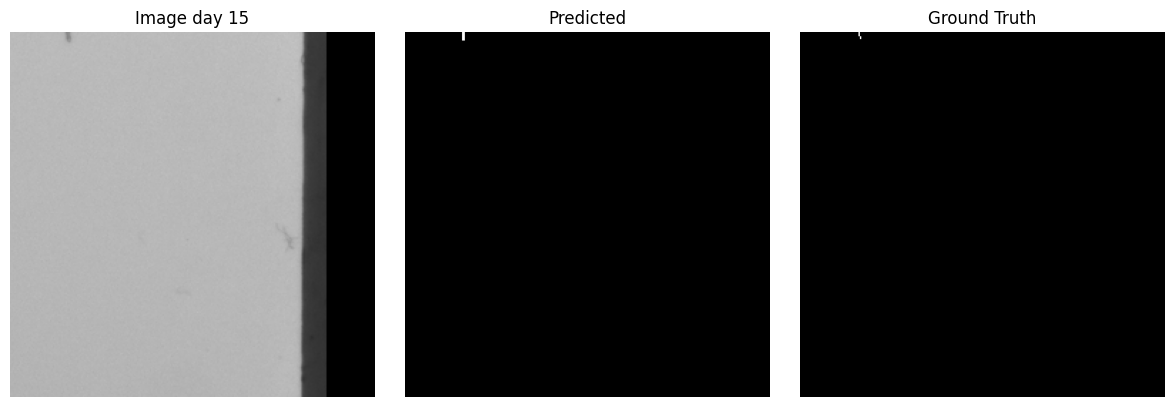

1/1 [==============================] - 0s 111ms/step
('28', '05', '13'): days=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.3744 IoU=0.2303 P=0.2593 R=0.6734


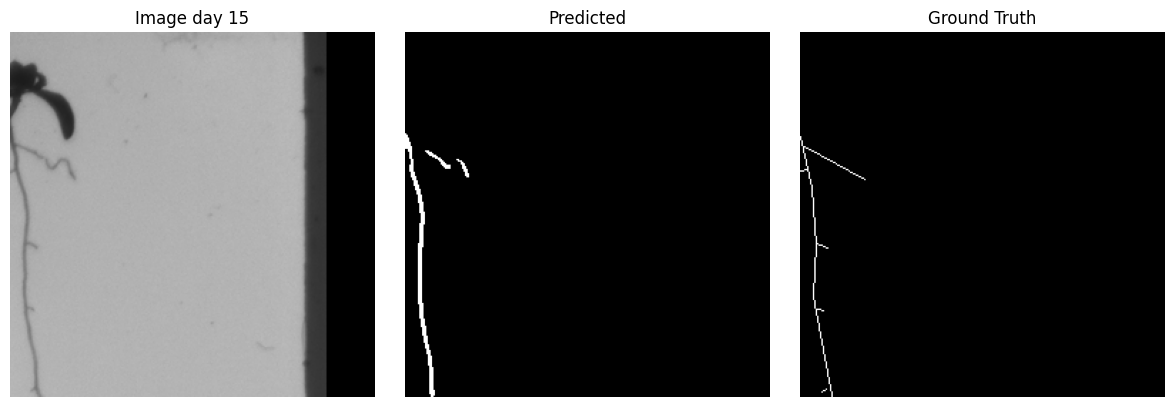

1/1 [==============================] - 0s 131ms/step
('28', '05', '23'): days=[11, 12, 13, 14, 15] padded=True -> F1=0.3623 IoU=0.2213 P=0.2462 R=0.6860


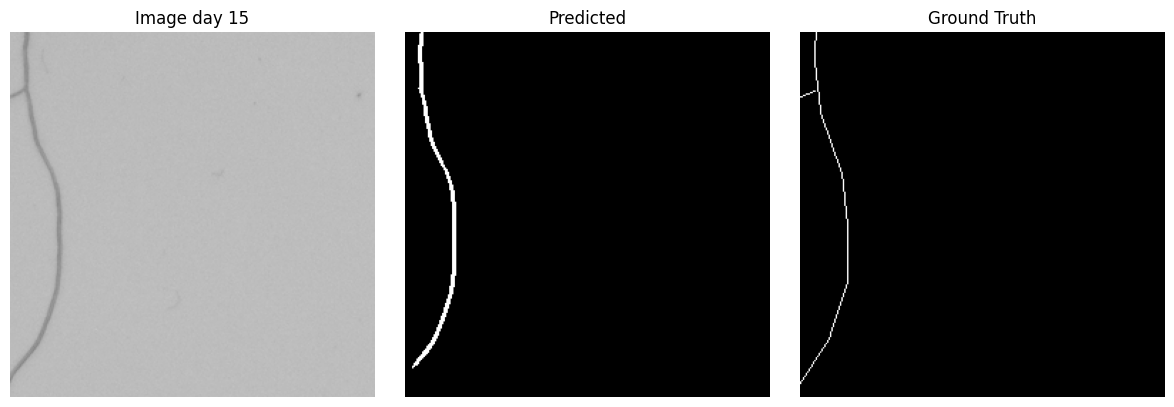

1/1 [==============================] - 0s 118ms/step
('28', '05', '09'): days=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.3127 IoU=0.1853 P=0.2243 R=0.5160


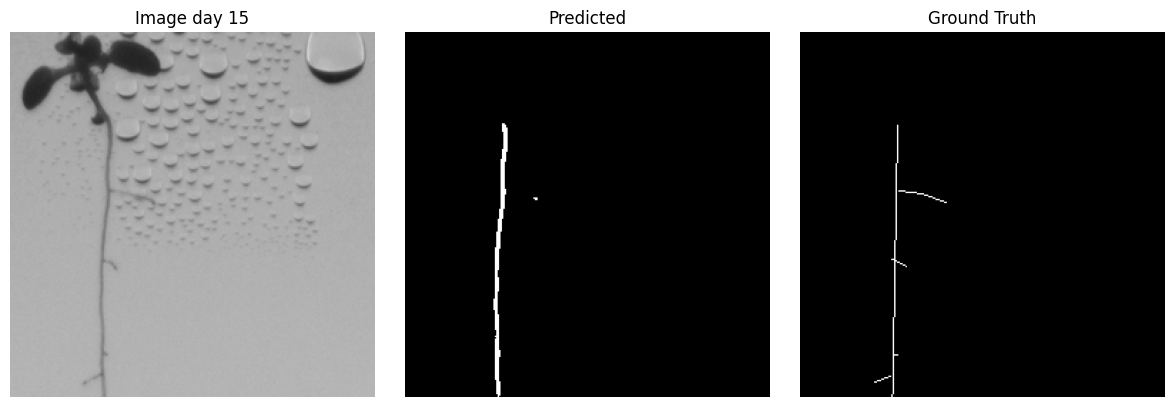

1/1 [==============================] - 0s 122ms/step
('28', '05', '10'): days=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.2693 IoU=0.1556 P=0.1995 R=0.4140


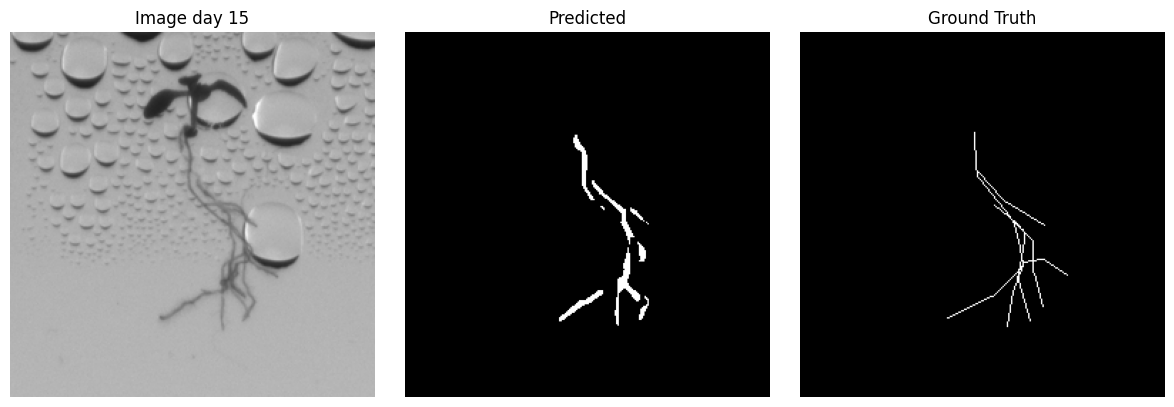

1/1 [==============================] - 0s 97ms/step
('28', '05', '11'): days=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.2743 IoU=0.1589 P=0.2209 R=0.3618


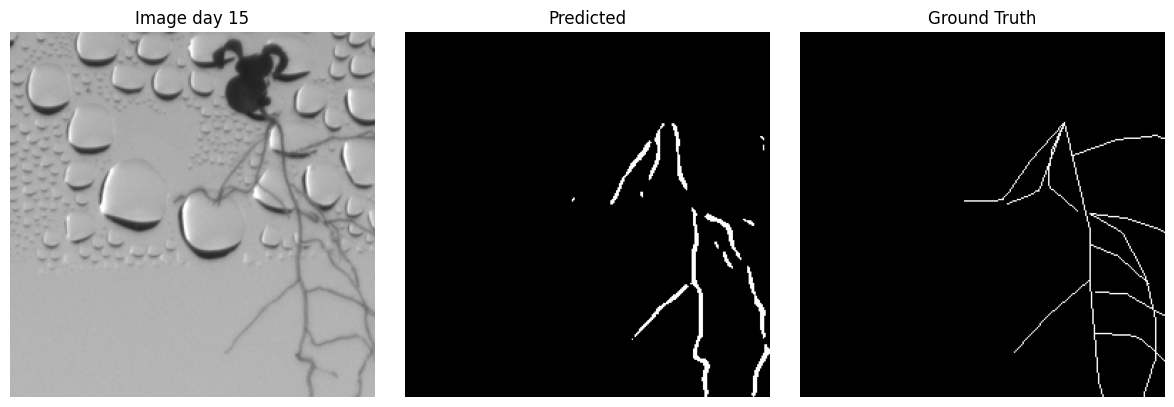

1/1 [==============================] - 0s 108ms/step
('28', '05', '08'): days=[2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.1591 IoU=0.0864 P=0.1250 R=0.2188


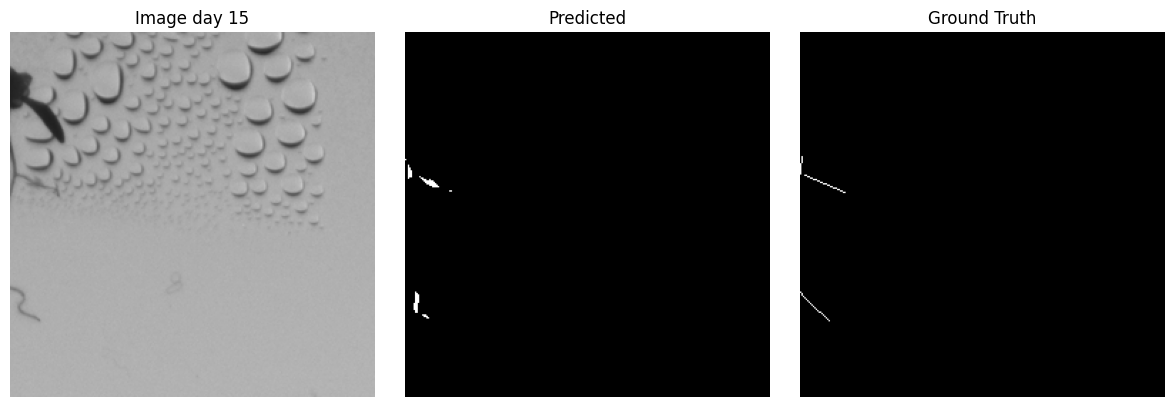

1/1 [==============================] - 0s 132ms/step
('28', '05', '20'): days=[6, 7, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.3918 IoU=0.2436 P=0.2690 R=0.7204


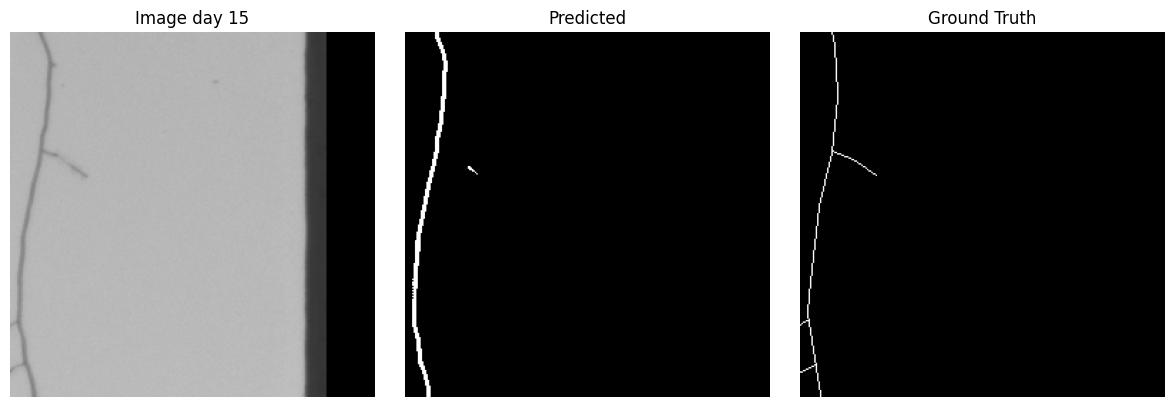

1/1 [==============================] - 0s 116ms/step
('28', '05', '12'): days=[4, 5, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.0459 IoU=0.0235 P=0.0461 R=0.0458


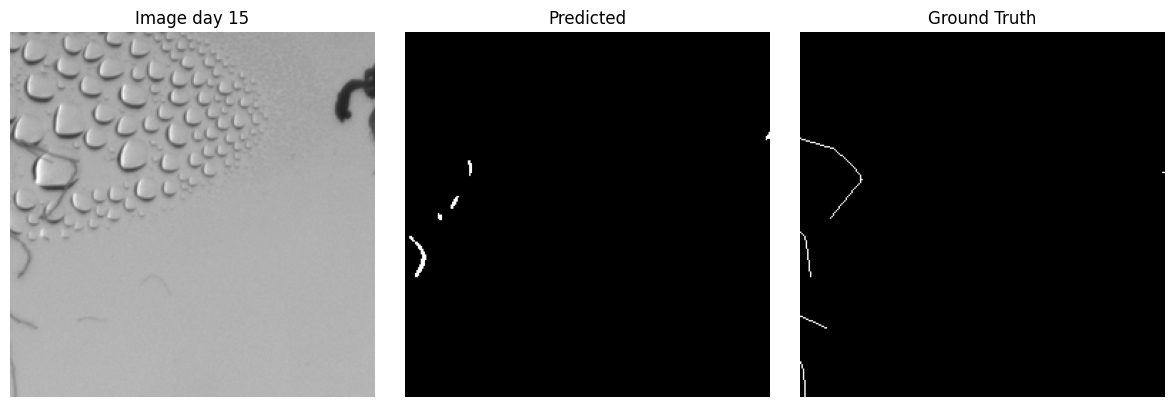

1/1 [==============================] - 0s 129ms/step
('28', '05', '16'): days=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.2932 IoU=0.1718 P=0.2025 R=0.5309


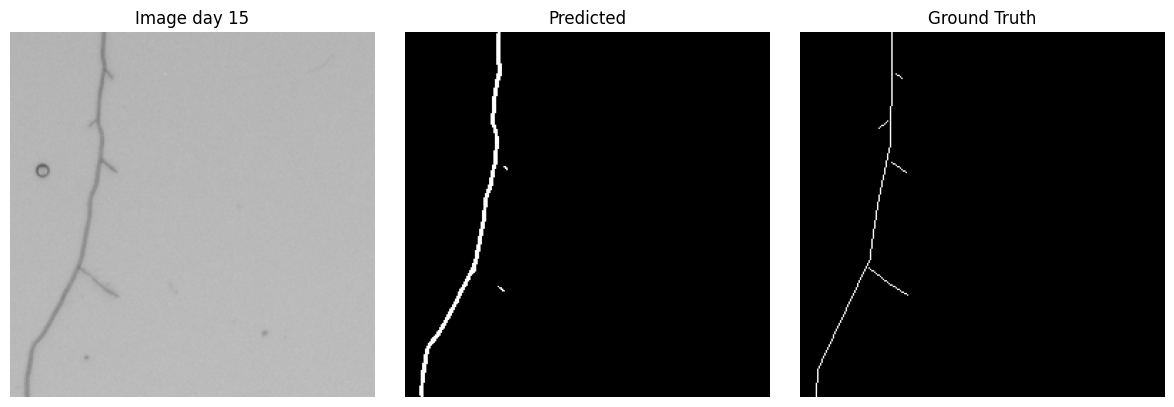

1/1 [==============================] - 0s 134ms/step
('28', '05', '07'): days=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.3370 IoU=0.2026 P=0.2338 R=0.6034


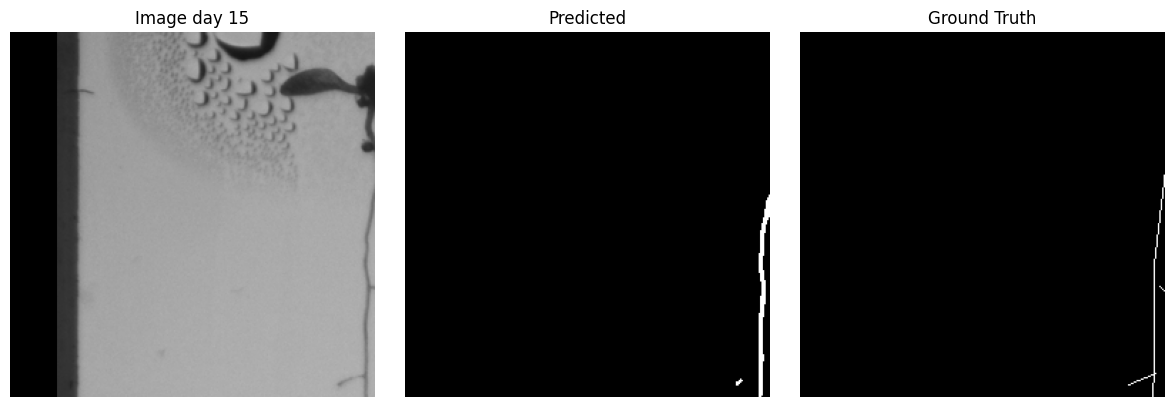

1/1 [==============================] - 0s 126ms/step
('28', '05', '27'): days=[11, 12, 13, 14, 15] padded=True -> F1=0.3451 IoU=0.2085 P=0.2263 R=0.7266


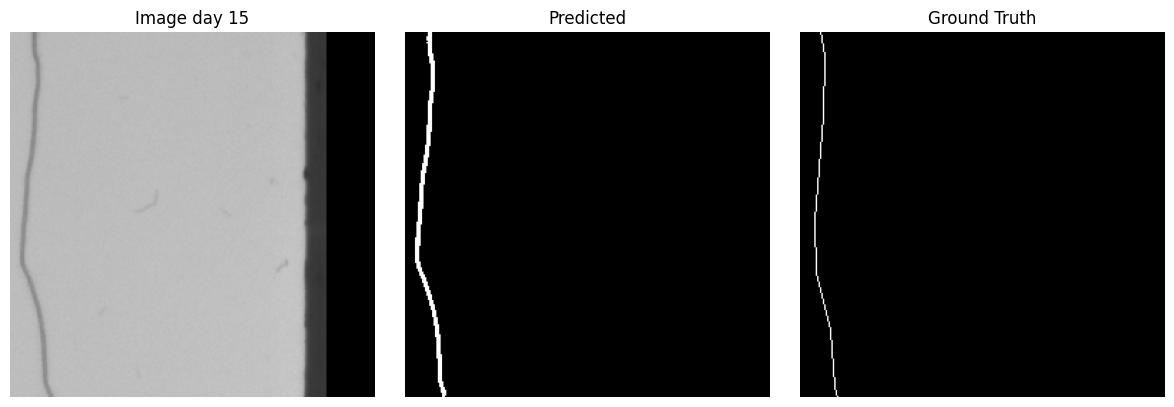

1/1 [==============================] - 0s 110ms/step
('28', '05', '29'): days=[15] padded=True -> F1=0.0784 IoU=0.0408 P=0.0541 R=0.1429


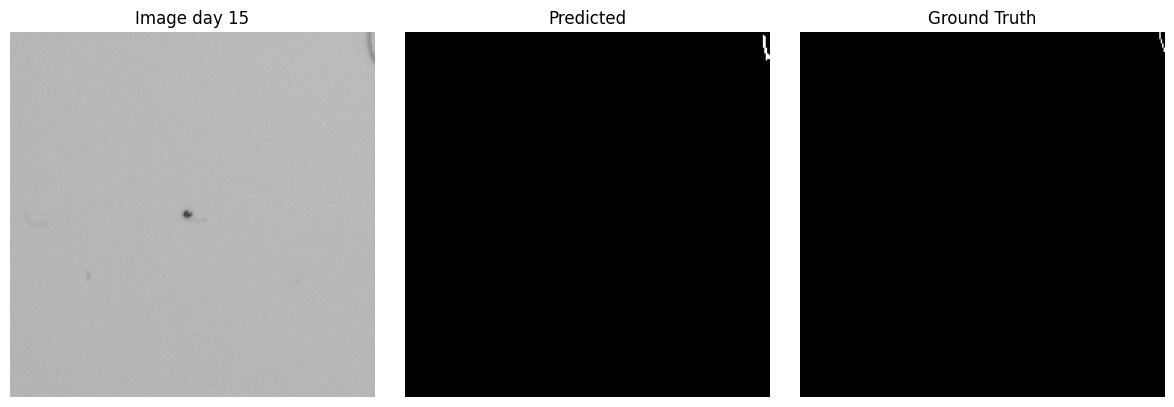

1/1 [==============================] - 0s 133ms/step
('28', '05', '14'): days=[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.3062 IoU=0.1807 P=0.2125 R=0.5473


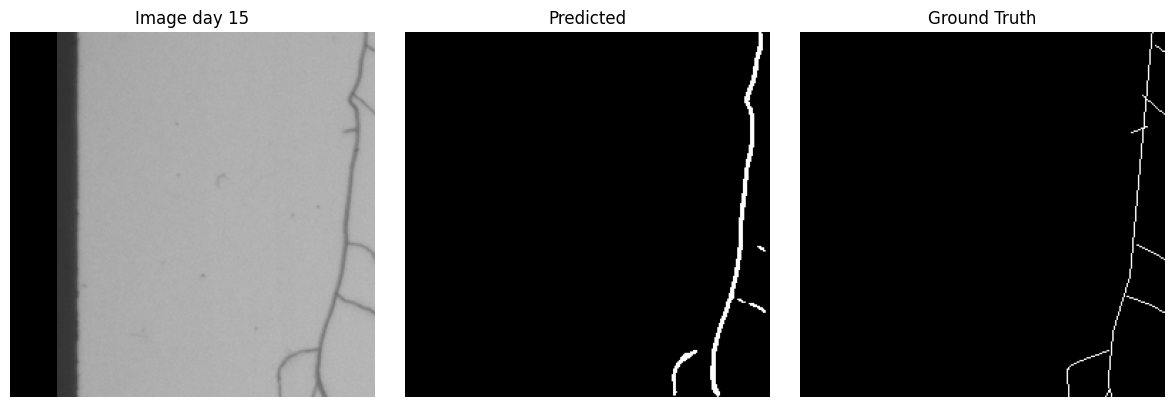

1/1 [==============================] - 0s 131ms/step
('28', '05', '18'): days=[7, 8, 9, 10, 11, 12, 13, 14, 15] padded=True -> F1=0.2235 IoU=0.1258 P=0.1597 R=0.3725


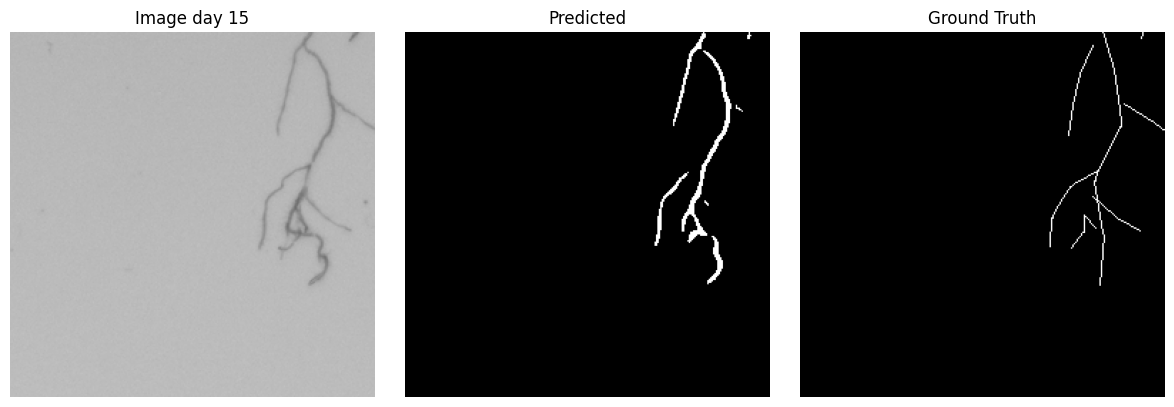

1/1 [==============================] - 0s 133ms/step
('28', '05', '34'): days=[15] padded=True -> F1=0.4096 IoU=0.2576 P=0.2685 R=0.8633


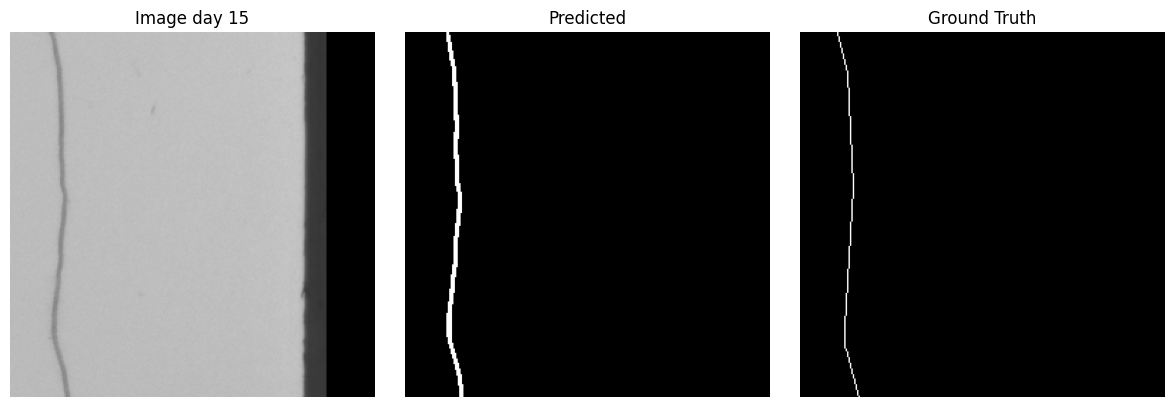

1/1 [==============================] - 0s 125ms/step
('28', '05', '21'): days=[11, 12, 13, 14, 15] padded=True -> F1=0.3008 IoU=0.1771 P=0.1994 R=0.6125


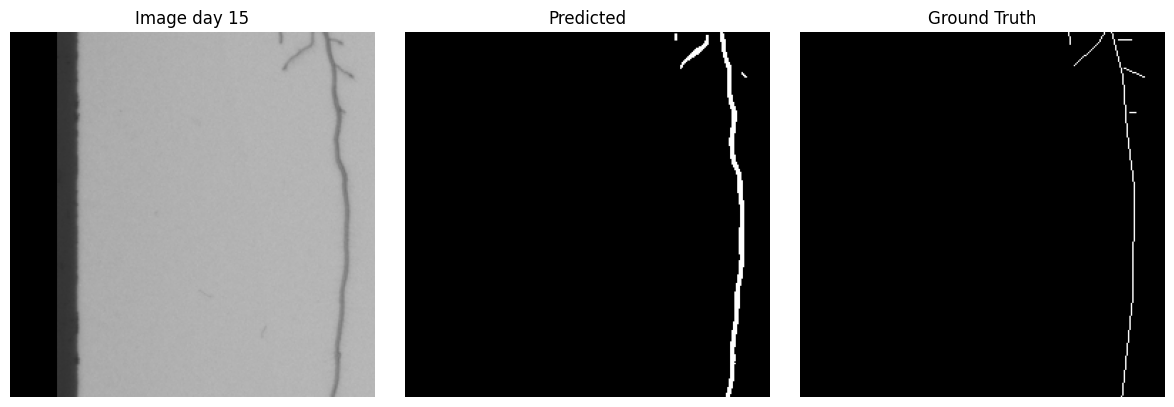

1/1 [==============================] - 0s 125ms/step
('28', '05', '15'): days=[11, 12, 13, 14, 15] padded=True -> F1=0.0000 IoU=0.0000 P=0.0000 R=0.0000


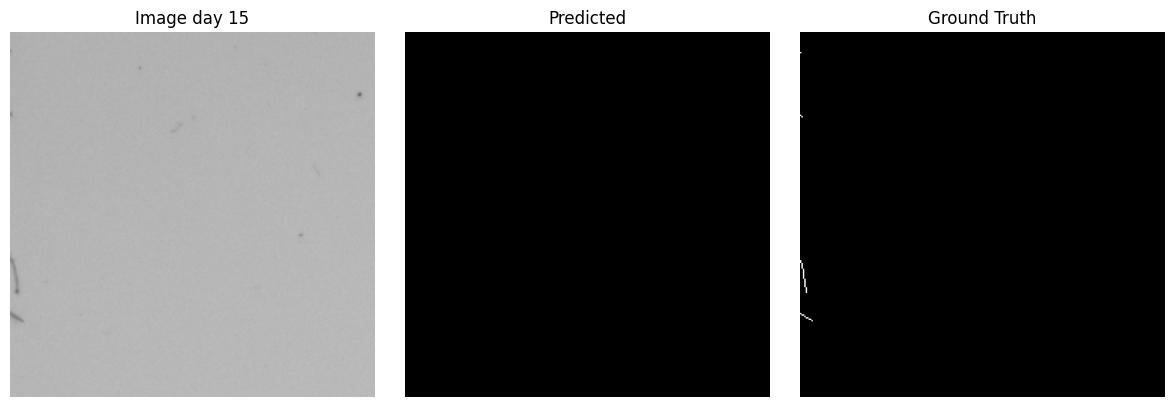

1/1 [==============================] - 0s 104ms/step
('28', '05', '28'): days=[15] padded=True -> F1=0.3009 IoU=0.1771 P=0.1962 R=0.6456


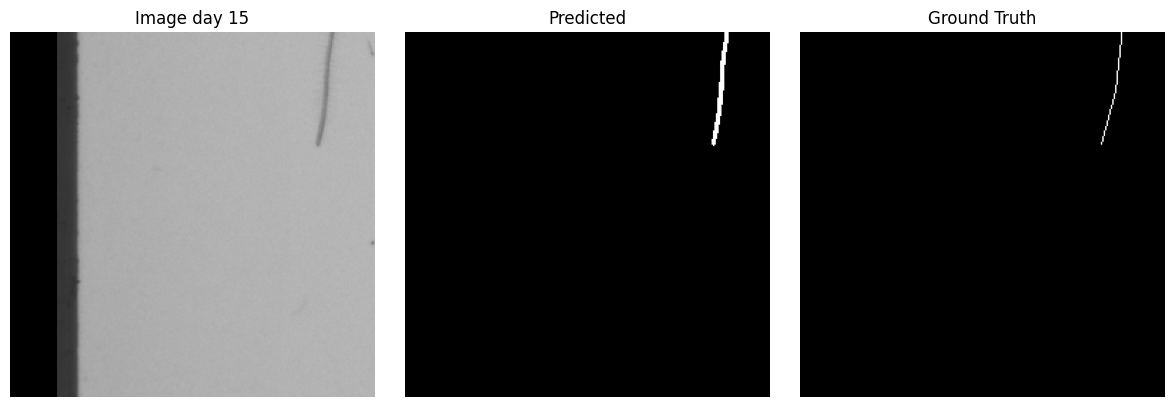

1/1 [==============================] - 0s 113ms/step
('28', '05', '30'): days=[15] padded=True -> F1=0.4056 IoU=0.2544 P=0.2750 R=0.7727


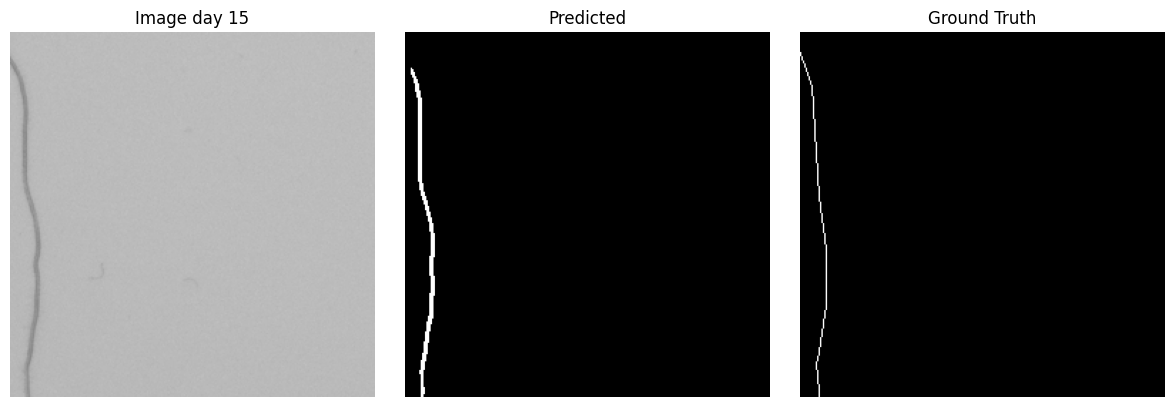

1/1 [==============================] - 0s 132ms/step
('28', '05', '22'): days=[15] padded=True -> F1=0.3529 IoU=0.2143 P=0.2927 R=0.4444


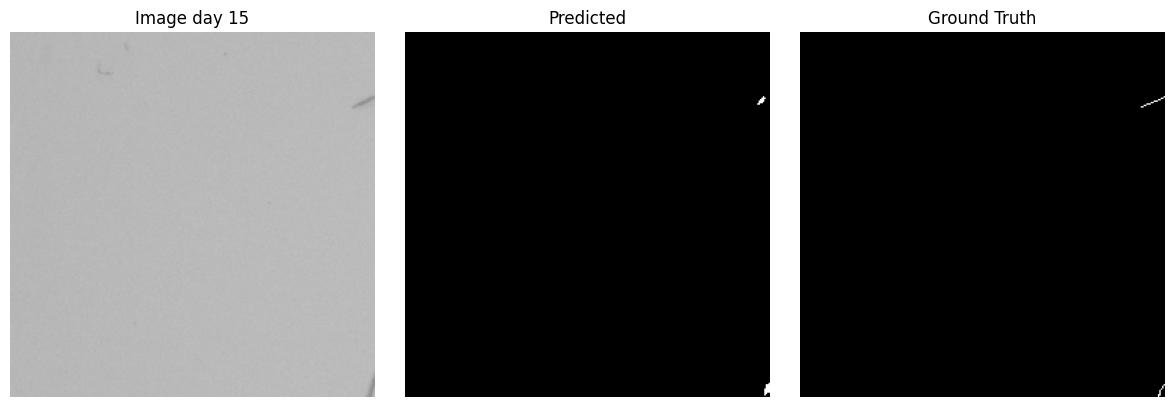

1/1 [==============================] - 0s 139ms/step
('28', '05', '19'): days=[15] padded=True -> F1=0.0000 IoU=0.0000 P=0.0000 R=0.0000


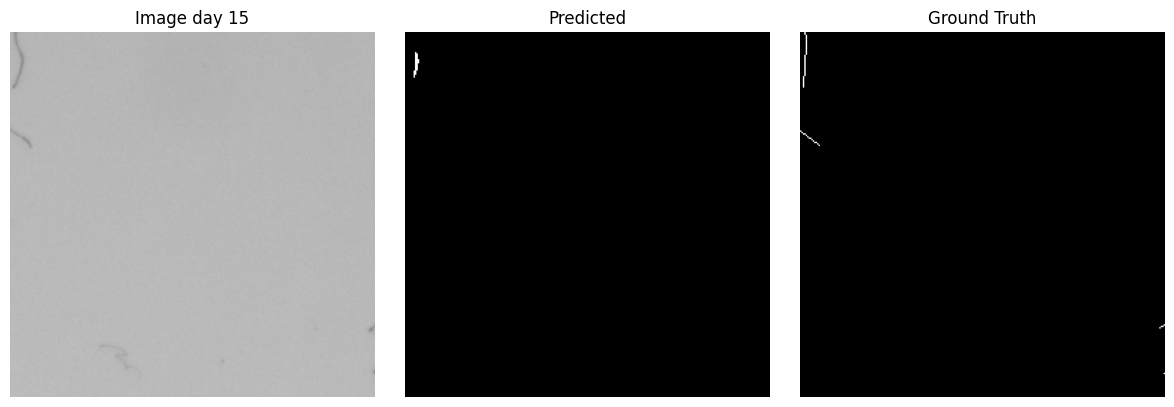

1/1 [==============================] - 0s 127ms/step
('28', '05', '37'): days=[15] padded=True -> F1=0.5098 IoU=0.3421 P=0.3611 R=0.8667


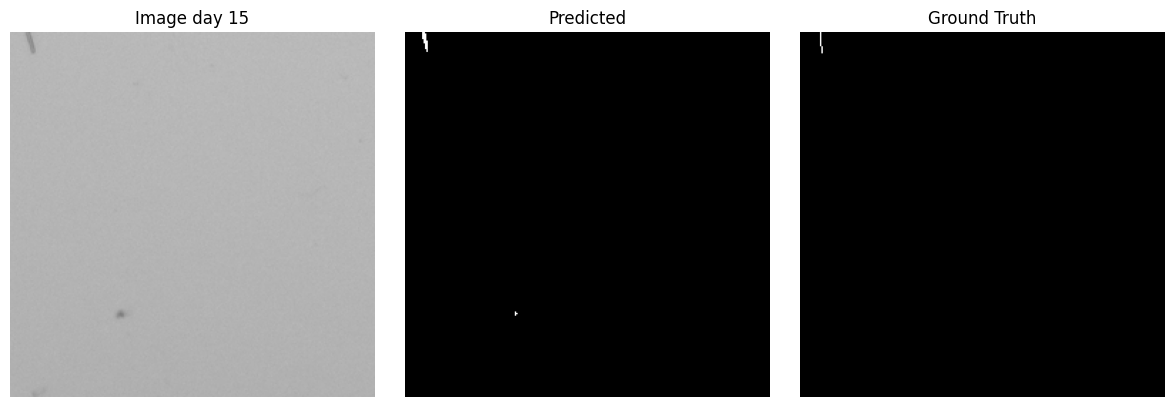


=== Average Metrics ===
Avg F1 Score: 0.2785
Avg mIoU:     0.1684
Avg Precision:0.1966
Avg Recall:   0.4941


{'per_sequence': [{'key': ('28', '05', '41'),
   'days': [15],
   'padded': True,
   'f1': 0.35294117647058826,
   'iou': 0.21428571428571427,
   'precision': 0.25,
   'recall': 0.6,
   'last_day': 15},
  {'key': ('28', '05', '13'),
   'days': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
   'padded': True,
   'f1': 0.3744394618834081,
   'iou': 0.2303448275862069,
   'precision': 0.2593167701863354,
   'recall': 0.6733870967741935,
   'last_day': 15},
  {'key': ('28', '05', '23'),
   'days': [11, 12, 13, 14, 15],
   'padded': True,
   'f1': 0.3623336745138178,
   'iou': 0.22125,
   'precision': 0.24617524339360222,
   'recall': 0.686046511627907,
   'last_day': 15},
  {'key': ('28', '05', '09'),
   'days': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
   'padded': True,
   'f1': 0.31272727272727274,
   'iou': 0.1853448275862069,
   'precision': 0.22434782608695653,
   'recall': 0.516,
   'last_day': 15},
  {'key': ('28', '05', '10'),
   'days': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from tensorflow.keras.models import load_model
from sklearn.metrics import (
    jaccard_score,
    precision_score,
    recall_score,
    f1_score as f1_metric,
)

from helpers import f1  # your custom metric used when loading the model


# ------------------------------------------------------------------
# Parsing utilities
# ------------------------------------------------------------------
def parse_patch_filename(fname):
    """
    Expected pattern: EXP_PLATE_DAY_PATCH.ext
    Example: 28_01_02_03.png -> (exp='28', plate='01', day=2, patch='03')
    """
    stem = os.path.splitext(fname)[0]
    parts = stem.split("_")
    if len(parts) != 4:
        raise ValueError(f"Filename {fname} does not match 'exp_plate_day_patch' pattern.")
    exp, plate, day_str, patch_id = parts
    return exp, plate, int(day_str), patch_id


def list_files_with_ext(dir_path, exts):
    exts = tuple(e.lower() for e in exts)
    return [f for f in os.listdir(dir_path) if f.lower().endswith(exts)]


# ------------------------------------------------------------------
# Grouping
# ------------------------------------------------------------------
def build_group_dict(dir_path, img_exts=(".png", ".jpg", ".jpeg")):
    """
    Returns:
        group_dict[(exp, plate, patch_id)] = list of (day, full_path)
    """
    group_dict = defaultdict(list)
    for fname in list_files_with_ext(dir_path, img_exts):
        try:
            exp, plate, day, patch_id = parse_patch_filename(fname)
        except ValueError:
            # Skip files that don't match naming pattern
            continue
        full_path = os.path.join(dir_path, fname)
        group_dict[(exp, plate, patch_id)].append((day, full_path))
    # sort by day
    for k in group_dict:
        group_dict[k].sort(key=lambda x: x[0])
    return group_dict


# ------------------------------------------------------------------
# Loading sequences
# ------------------------------------------------------------------
def load_patches_sequence(group_dict, time_steps=15, patch_size=256, as_rgb=True):
    """
    Build model-ready sequences.

    Args:
        group_dict: dict from build_group_dict()
        time_steps: desired temporal length (pad/truncate)
        patch_size: resize target
        as_rgb: if True, ensure 3 channels

    Returns:
        sequences: list of dicts:
            {
              'key': (exp, plate, patch_id),
              'days': [list of sorted day ints BEFORE padding/truncation],
              'seq': np.array shape (time_steps, H, W, C),
            }
    """
    sequences = []
    for key, day_path_list in group_dict.items():
        days_sorted = [d for d, _ in day_path_list]

        # load images
        frames = []
        for _, path in day_path_list:
            if as_rgb:
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # promote to 3ch for model

            # resize safeguard
            if img.shape[0] != patch_size or img.shape[1] != patch_size:
                img = cv2.resize(img, (patch_size, patch_size), interpolation=cv2.INTER_AREA)

            frames.append(img.astype(np.float32) / 255.0)

        if not frames:
            continue  # nothing loaded

        # pad / truncate
        if len(frames) < time_steps:
            pad_frame = frames[-1]
            frames = frames + [pad_frame] * (time_steps - len(frames))
            padded = True
        else:
            frames = frames[:time_steps]
            padded = False

        seq = np.stack(frames, axis=0)  # (T, H, W, 3)

        sequences.append({
            "key": key,
            "days": days_sorted,
            "seq": seq,
            "padded": padded,
        })

    return sequences


# ------------------------------------------------------------------
# Mask loading helper
# ------------------------------------------------------------------
def load_mask_for_day(mask_dir, exp, plate, day, patch_id, patch_size=256):
    """
    Load a single mask file with .tif extension: EXP_PLATE_DAY_PATCH.tif
    Returns float32 array in [0,1] shape (H,W).
    """
    fname = f"{exp}_{plate}_{day:02d}_{patch_id}.tif"
    path = os.path.join(mask_dir, fname)
    if not os.path.exists(path):
        return None, fname
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None, fname
    if mask.shape[0] != patch_size or mask.shape[1] != patch_size:
        mask = cv2.resize(mask, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)
    mask = (mask.astype(np.float32) / 255.0)
    return mask, fname


# ------------------------------------------------------------------
# Prediction wrapper (handles models w/ or w/o time dim in output)
# ------------------------------------------------------------------
def predict_last_frame(model, seq_input):
    """
    seq_input: (1, T, H, W, C)
    Returns 2D prediction array (H, W) in [0,1].
    Handles:
      - model output (1, T, H, W, 1)  -> take last T
      - model output (1, H, W, 1)     -> already collapsed
      - model output (1, H, W)        -> channel squeezed
    """
    pred = model.predict(seq_input)

    # Convert Tensor-like to np.array if needed
    pred = np.array(pred)

    if pred.ndim == 5:
        # (B, T, H, W, C)
        pred_last = pred[0, -1, :, :, 0] if pred.shape[-1] > 1 else pred[0, -1, :, :, 0]
    elif pred.ndim == 4:
        # (B, H, W, C)
        pred_last = pred[0, :, :, 0] if pred.shape[-1] == 1 else pred[0, :, :, 0]
    elif pred.ndim == 3:
        # (B, H, W)
        pred_last = pred[0, :, :]
    else:
        raise ValueError(f"Unexpected prediction ndim={pred.ndim}; shape={pred.shape}")

    return pred_last


# ------------------------------------------------------------------
# Main pipeline
# ------------------------------------------------------------------
def pipeline(
    image_dir,
    mask_dir=None,
    time_steps=15,
    patch_size=256,
    threshold=0.5,
    plot_examples=True,
):
    """
    Inference + metrics over patch sequences for LSTM U-Net.

    Args:
        image_dir: path containing patch images (.png)
        mask_dir: path containing masks (.tif); inferred if None
        time_steps: number of frames per sequence expected by model
        patch_size: spatial size
        threshold: binarization cutoff
        plot_examples: show qualitative results

    Prints metrics and returns a dict with per-sequence results + averages.
    """
    if mask_dir is None:
        mask_dir = image_dir.replace("images/images", "masks/masks")

    # Load model
    model_path = "lstm_unet_model.h5"
    model = load_model(model_path, custom_objects={"f1": f1})

    # Build groups
    group_dict = build_group_dict(image_dir, img_exts=(".png",))
    print(f"Found {len(group_dict)} (exp, plate, patch) groups in {image_dir}.")

    # Load sequences
    sequences = load_patches_sequence(group_dict, time_steps=time_steps, patch_size=patch_size, as_rgb=True)
    print(f"Built {len(sequences)} sequences (each padded/truncated to {time_steps} frames).")

    all_f1 = []
    all_iou = []
    all_precision = []
    all_recall = []

    results = []

    for seq_info in sequences:
        key = seq_info["key"]
        days_sorted = seq_info["days"]
        seq = seq_info["seq"]
        padded = seq_info["padded"]

        exp, plate, patch_id = key

        # Model input
        seq_input = np.expand_dims(seq, axis=0)  # (1, T, H, W, 3)

        # Predict last frame
        prediction = predict_last_frame(model, seq_input)  # (H, W) float
        prediction_bool = (prediction >= threshold).astype(np.uint8)

        # Ground-truth: use *last actual day available* in this group
        last_day = days_sorted[-1]
        mask, mask_fname = load_mask_for_day(mask_dir, exp, plate, last_day, patch_id, patch_size=patch_size)
        if mask is None:
            print(f"[WARN] Missing mask file {mask_fname}; skipping metrics for {key}.")
            continue
        mask_bool = (mask >= threshold).astype(np.uint8)

        # Metrics
        pred_flat = prediction_bool.flatten()
        mask_flat = mask_bool.flatten()

        # Some masks may be all 0; guard for undefined precision/recall
        # Use zero_division=0 to avoid warnings
        f1_val = f1_metric(mask_flat, pred_flat, zero_division=0)
        iou_val = jaccard_score(mask_flat, pred_flat, zero_division=0)
        precision_val = precision_score(mask_flat, pred_flat, zero_division=0)
        recall_val = recall_score(mask_flat, pred_flat, zero_division=0)

        all_f1.append(f1_val)
        all_iou.append(iou_val)
        all_precision.append(precision_val)
        all_recall.append(recall_val)

        print(
            f"F1={f1_val:.4f} IoU={iou_val:.4f} P={precision_val:.4f} R={recall_val:.4f}"
        )

        results.append({
            "key": key,
            "days": days_sorted,
            "padded": padded,
            "f1": f1_val,
            "iou": iou_val,
            "precision": precision_val,
            "recall": recall_val,
            "last_day": last_day,
        })

        if plot_examples:
            # show last available image for context: if padded, show actual last
            actual_last_idx = min(len(days_sorted) - 1, seq.shape[0] - 1)
            img_last = seq[actual_last_idx]

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img_last)
            axs[0].set_title(f"Image day {days_sorted[-1]:02d}")
            axs[0].axis("off")

            axs[1].imshow(prediction_bool, cmap="gray")
            axs[1].set_title("Predicted")
            axs[1].axis("off")

            axs[2].imshow(mask_bool, cmap="gray")
            axs[2].set_title("Ground Truth")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

    # Summary
    if all_f1:
        avg_f1 = float(np.mean(all_f1))
        avg_iou = float(np.mean(all_iou))
        avg_p = float(np.mean(all_precision))
        avg_r = float(np.mean(all_recall))
        print("\n=== Average Metrics ===")
        print(f"Avg F1 Score: {avg_f1:.4f}")
        print(f"Avg mIoU:     {avg_iou:.4f}")
        print(f"Avg Precision:{avg_p:.4f}")
        print(f"Avg Recall:   {avg_r:.4f}")
    else:
        avg_f1 = avg_iou = avg_p = avg_r = None
        print("\nNo valid sequences/masks were processed.")

    return {
        "per_sequence": results,
        "avg_f1": avg_f1,
        "avg_iou": avg_iou,
        "avg_precision": avg_p,
        "avg_recall": avg_r,
        "num_sequences": len(results),
    }


# ------------------------------------------------------------------
# Example usage
# ------------------------------------------------------------------

pipeline('data_v2_processed/test')
